In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np 
import torch 
import metatensor 
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.features.acdc import *
from mlelec.features.acdc_utils import *    
from ase.io import read


/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
filename = "graphene_supercell_variety"
names = ['ortho', 'hex', 'double_hex', 'triple_hex', 'hex23']
# names = ['hex', 'double_hex']
frames = read('examples/data/periodic/{}/graphene_variety.xyz'.format(filename), ':')
# kmesh = [[2,2,1], [1,1,1]]
kspacing = 0.5
kmesh = [[np.int32(np.max([1, np.ceil(2*np.pi*np.linalg.norm(vec)/kspacing)])) for vec in frame.cell.reciprocal().array] for frame in frames]

for f in frames:
    f.pbc = [True, True, True]
# kfock = [np.load('examples/data/periodic/{}/fock_{}.npy'.format(filename,name)) for name in names]
kfock = {name: np.load('examples/data/periodic/{}/fock_{}.npy'.format(filename,name)) for name in names}
# kfock = {name: np.load('examples/data/periodic/{}/over_{}.npy'.format(filename,name)) for name in names}

dataset = {name: PySCFPeriodicDataset(frames = [frames[i]], kgrid=kmesh[i], matrices_kpoint = kfock[name].reshape(1, *kfock[name].shape), target=["real_translation"] ,device = "cpu") for i,name in enumerate(names)}


In [4]:
from mlelec.utils.twocenter_utils import fix_orbital_order
orbs = {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}

for name in dataset: 
    for T in dataset[name].matrices_translation: 
       dataset[name].matrices_translation[T] = fix_orbital_order(dataset[name].matrices_translation[T], dataset[name].structures, orbs)


In [5]:
from mlelec.utils.twocenter_utils import _to_blocks, _to_coupled_basis
def get_targets(dataset, device ="cpu"):
    matrices = {tuple(s): dataset.matrices_translation[tuple(s)] for s in dataset.desired_shifts}
    target_blocks = {}
    target_blocks = {}
    target_coupled_blocks = {}
    for s in dataset.desired_shifts:
        target_blocks[tuple(s)] = _to_blocks(matrices[tuple(s)], frames=dataset.structures, orbitals=orbs, NH=True, device=device) # matrix -> uncoupled
        # Dont forget NH = True
        target_coupled_blocks[tuple(s)] = _to_coupled_basis(target_blocks[tuple(s)], orbs, skip_symmetry=True, device= device) # uncouple -> coupled
        # Dont forget skip_symmetry = True

    

    blocks = []
    tmap_keys = []
    for translation in target_coupled_blocks.keys():
        for i, (key, block) in enumerate(target_coupled_blocks[translation].items()):
            blocks.append(block.copy())
            x = list(key)
            x.extend(translation)
            tmap_keys.append(x)
    keys = Labels(next(iter(target_coupled_blocks.values())).keys.names+["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.asarray(tmap_keys))
    target = TensorMap(keys=keys, blocks=blocks)

    target = target.keys_to_samples('cell_shift_a')
    target = target.keys_to_samples('cell_shift_b')
    target = target.keys_to_samples('cell_shift_c')
    return target , target_coupled_blocks


In [6]:
target = {name: get_targets(dataset[name])[0] for name in dataset}
target_coupled_blocks = {name: get_targets(dataset[name])[1] for name in dataset}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/twocenter_utils.py:162: UserWarning: Matrix is neither hermitian nor antihermitian - attempting to use _toblocks for NH
  warnings.warn(


In [89]:
filename = "graphene_supercell_variety"
names = ['ortho', 'hex', 'double_hex', 'triple_hex', 'hex23']
new_names=['ortho', 'hex', 'hex22', 'hex33', 'hex23']
frames = read('examples/data/periodic/{}/graphene_variety.xyz'.format(filename), ':')
kspacing = 0.5
kmesh = [[np.int32(np.max([1, np.ceil(2*np.pi*np.linalg.norm(vec)/kspacing)])) for vec in frame.cell.reciprocal().array] for frame in frames]

for f in frames:
    f.pbc = [True, True, True]
# kfock = [np.load('examples/data/periodic/{}/fock_{}.npy'.format(filename,name)) for name in names]
kfock = {nname: np.load('examples/data/periodic/{}/fock_{}.npy'.format(filename,name)) for nname, name in zip(new_names,names)}
# kfock = {name: np.load('examples/data/periodic/{}/over_{}.npy'.format(filename,name)) for name in names}

dataset = {name: PySCFPeriodicDataset(frames = [frames[i]], kgrid=kmesh[i], matrices_kpoint = kfock[name].reshape(1, *kfock[name].shape), target=["real_translation"] ,device = "cpu") for i,name in enumerate(new_names)}




In [118]:
frame_original = dataset['hex'].structures[0].copy()
frame = dataset['hex'].structures[0].copy()
new_positions = frame.positions.copy()
new_positions[0] += 10
frame.set_positions(new_positions)

kmesh = [6,6,1]
fcopy = frame.copy()
fcopy.wrap()
superframe = fcopy.repeat(kmesh) # works 
# superframe = frame.repeat(kmesh) # doesnt work 
i = 1
j = 0
for T in dataset['hex'].desired_shifts:
    # T = [4,0,0]
    J = scidx_from_unitcell(frame, j, T, kmesh)
    cell_inv = np.linalg.inv(frame.cell.array.T)
    d = superframe.positions[J] #.get_all_distances(mic=)
    tvect = np.floor(cell_inv @ d)
    # tvect = cell_inv @ d
    norm = np.linalg.norm(tvect-T)
    if norm > 1e-5:
        print(norm, T, tvect)
    # print(np.linalg.norm(tvect-T))
# def unitcellidx_

In [119]:
# tvect, np.mod(-tvect, kmesh)
# print(-2%6)

(array([5., 5., 0.]), array([1., 1., 0.]))

In [135]:
target_coupled_blocks['hex'][tuple(T)][11].samples, 

Labels(
    structure  center  neighbor
        0        0        1
)

In [186]:

np.asarra(orbs[6])

{6: [[1, 0, 0], [2, 0, 0], [2, 1, 1], [2, 1, -1], [2, 1, 0]]}

In [211]:
orbs_mult = {tuple(k):v for k,v in zip(*np.unique(np.asarray(orbs[6])[:,:2], axis=0, return_counts=True))}
# shapes = tuple([tuple([(orbs_mult[tuple(k2)], orbs_mult[tuple(k1)]) for k1 in orbs_mult]) for k2 in orbs_mult])
shapes = tuple([tuple([(orbs_mult[tuple(k2)], orbs_mult[tuple(k1)]) for k1 in orbs_mult]) for k2 in orbs_mult])

In [212]:
shapes.shape

(((1, 1), (1, 1), (1, 3)), ((1, 1), (1, 1), (1, 3)), ((3, 1), (3, 1), (3, 3)))

In [213]:
view_as_blocks(matrices[0,0,0][0][0:5,0:5],shapes)

ValueError: 'block_shape' must have the same length as 'arr_in.shape'

In [190]:
np.transpose(shapes)

array([[[1, 1, 1],
        [1, 1, 1],
        [3, 3, 3]],

       [[1, 1, 3],
        [1, 1, 3],
        [1, 1, 3]]])

In [160]:
# from mlelec.utils.twocenter_utils import _mat
blocks = []
labels = []
natoms = frame.get_global_number_of_atoms()
nao = 5 # calculate based on atomic orbitals per species 
from skimage.util import view_as_blocks 
# view_as_blocks??
# for i, si in enumerate(frame.numbers):
#     for j,sj in enumerate(frame.numbers): 
#         for T in dataset['hex'].desired_shifts:
#             if i==j and np.all(T==0):
#                 Hii = matrices[tuple(T)][0].reshape(natoms,nao,natoms,nao)[i,:,i,:]
#                 blocks.append(TensorBlock(values = Hii, 
#                                           components=[[Labels(['m1']), Labels(['m2'])]]
#                                           )
                
#             elif si ==sj :
#             # btype 1 
            
#                 HijT = matrices[tuple(T)][0].reshape(natoms,nao,natoms,nao)[i,:,j,:]
#                 HjimT = matrices[tuple(np.mod(-np.array(T),kmesh))].reshape(2,5,2,5)[j,:,i,:]
#                 btype1 = HijT + HjimT
#                 btypem1 = HijT - HjimT

#                 norm = torch.linalg.norm(HijT - HjimT.T)
#                 if norm>1e-5:
#                     print(norm, T)
#         else:
#             raise ValueError("Not implemented")

In [162]:
view_as_blocks??

Signature: view_as_blocks(arr_in, block_shape)
Source:   
def view_as_blocks(arr_in, block_shape):
    """Block view of the input n-dimensional array (using re-striding).

    Blocks are non-overlapping views of the input array.

    Parameters
    ----------
    arr_in : ndarray
        N-d input array.
    block_shape : tuple
        The shape of the block. Each dimension must divide evenly into the
        corresponding dimensions of `arr_in`.

    Returns
    -------
    arr_out : ndarray
        Block view of the input array.

    Examples
    --------
    >>> import numpy as np
    >>> from skimage.util.shape import view_as_blocks
    >>> A = np.arange(4*4).reshape(4,4)
    >>> A
    array([[ 0,  1,  2,  3],
           [ 4,  5,  6,  7],
           [ 8,  9, 10, 11],
           [12, 13, 14, 15]])
    >>> B = view_as_blocks(A, block_shape=(2, 2))
    >>> B[0, 0]
    array([[0, 1],
           [4, 5]])
    >>> B[0, 1]
    array([[2, 3],
           [6, 7]])
    >>> B[1, 0, 1, 1]
    13

In [143]:
matrices[tuple(T)][0][0:5, 0:5]

tensor([[-3.1247e-04, -3.5312e-04,  7.2109e-05, -2.0070e-05, -7.0341e-12],
        [-3.5426e-04, -1.7416e-04, -9.9856e-05,  1.3814e-03, -1.1733e-11],
        [-4.5030e-05,  1.3195e-03,  3.0000e-03, -2.3635e-03, -5.4945e-12],
        [ 5.8798e-05,  6.6954e-04,  3.1581e-04,  1.8263e-03, -1.9391e-12],
        [ 1.5494e-11,  1.0867e-11, -3.1119e-12,  6.2036e-12,  1.6905e-03]],
       dtype=torch.float64)

In [130]:
# give i, jT- find j (-T%kmesh) , i 

i=0; j =1; T = [4,0,0]

print(matrices[tuple(T)][0][i,j] - matrices[tuple(np.mod(-np.array(T),kmesh))][0][j,i])

matrices = dataset['hex'].matrices_translation


tensor(2.8866e-15, dtype=torch.float64)


In [8]:
hypers_pair = {'cutoff': 4,
          'max_radial':12, 
          'max_angular':4,
          'atomic_gaussian_width':0.6,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}

hypers_atom = {'cutoff': 4,
          'max_radial':10, 
          'max_angular':4,
          'atomic_gaussian_width':0.3,
          'center_atom_weight':1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
}
device = "cpu"

In [48]:

rhoij = {name:pair_features(dataset[name].structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = True, both_centers=True, max_shift = dataset[name].kmesh[0] ,  desired_shifts = dataset[name].desired_shifts_sup, mic=True, kmesh = dataset[name].kmesh[0], device="cpu") for i,name in enumerate(new_names[1:2])}

hypers_pair {'cutoff': 9.0, 'max_radial': 12, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


In [39]:
IFRAME = 0
I = 0
J = 1
for (k, b), (k2, b2) in zip(rhoij['hex'].items(), rhoij['hex22'].items()):

    sample_label = Labels(["structure", "center", "neighbor", "cell_shift_a", "cell_shift_b", "cell_shift_c", "cell_shift_a_MIC", "cell_shift_b_MIC","cell_shift_c_MIC",], values = np.array([[IFRAME, I, J, 0, 0, 0,0,0,0]]))

    idx_h = b.samples.position(sample_label[0])
    idx_h2 = b2.samples.position(sample_label[0])
    if idx_h is not None: 
        assert np.isclose(b.values[idx_h], b2.values[idx_h2]).all()
    else: 
        raise ValueError("HELL!")


KeyError: 'hex22'

In [64]:

rhonui = {name: single_center_features(dataset[name].structures, hypers_atom, order_nu=3, lcut=3, device = device,feature_names = rhoij[name].property_names,) for name in new_names[1:2]}


In [65]:
hfeat_tc= {name: twocenter_features_periodic_NH(single_center=rhonui[name], pair= rhoij[name]) for name in new_names[1:2]}

[3 1 0 6 6] skipped for btype0
[3 1 1 6 6] skipped for btype0
[3 1 2 6 6] skipped for btype0
[3 1 3 6 6] skipped for btype0
[ 3 -1  1  6  6] skipped for btype0
[ 3 -1  2  6  6] skipped for btype0
[ 3 -1  3  6  6] skipped for btype0
[ 3 -1  0  6  6] skipped for btype0


In [73]:
hfeat_tc['hex'][8].samples

Labels(
    structure  center  neighbor  cell_shift_a  cell_shift_b  cell_shift_c  cell_shift_a_MIC  cell_shift_b_MIC  cell_shift_c_MIC
        0        0        0           0             0             0               0                 0                 0
        0        0        0           0             1             0               0                 1                 0
        0        0        0           0             -1            0               0                 -1                0
        0        0        0           0             2             0               0                 2                 0
        0        0        0           0             -2            0               0                 -2                0
        0        0        0           0             3             0               0                 3                 0
        0        0        0           0             -3            0               0                 -3                0
        0        0      

In [64]:
from sklearn.decomposition import PCA


In [65]:
from mlelec.features.acdc_utils import _pca
hfeat_hexpca = _pca(hfeat['hex'])


KeyboardInterrupt: 

# LEARN 

In [45]:
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.plot_utils import plot_hamiltonian 

In [46]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges, kernels = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias)
    for s in pred:
        block_losses[s] = []
        for (key, block) in pred[s].items():
            block_loss=torch.sum(block.values - target_blocks[s][key].values)**2
            block_losses[s].append(block_loss)

    print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses, kernels 

In [47]:
def train_linear(model, target_blocks, nepochs, optimizer= None, log_interval =1):

    losses = []
    for epoch in range(nepochs):
        optimizer.zero_grad()
        pred = model(return_matrix = False)


        loss = 0
        for s in pred:
            for (key, block) in pred[s].items():
                loss+=torch.sum(block.values - target_blocks[s][key].values)**2
        losses.append(loss.item())
        if optimizer is None: 
            print(loss)
            return losses, pred, model
        
        loss.backward()
        optimizer.step()
        if epoch % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(
                epoch, loss.item()))
            

    return losses, pred, model, optimizer 

In [73]:
model_ridge = LinearModelPeriodic(twocfeat=hfeat['hex'], target_blocks=target['hex'], frames = dataset['hex'].structures, orbitals= orbs, cell_shifts=dataset['hex'].desired_shifts[:4], device = device)
# model_ridge = LinearModelPeriodic(twocfeat=hfeat_hexpca, target_blocks=target['hex'], frames = dataset['hex'].structures, orbitals= orbs, cell_shifts=dataset['hex'].desired_shifts[1:], device = device)

False
cpu
[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]] 4


In [74]:

loss_ridge_bias, pred_ridge_bias, ridges_bias, ridge_block_losses, kernels_ridge = train_ridge(model_ridge, target_coupled_blocks['hex'], set_bias=False)


0.001244295936420789


/home/nigam/miniconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


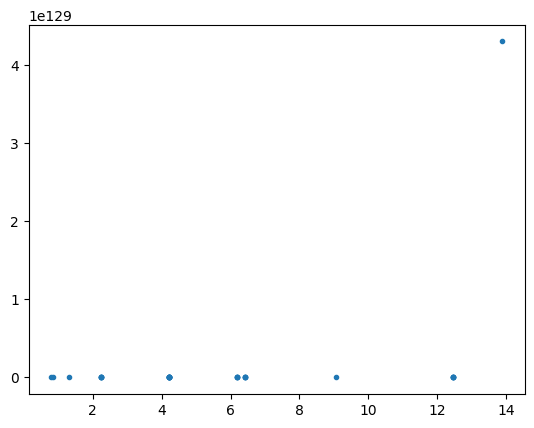

In [334]:
reg = 1.5
# kernels_ridge = [k/np.linalg.norm(k) for k in kernels_ridge]
norm_det = np.array([(np.linalg.norm(k), np.linalg.det(k+np.eye(k.shape[0])*reg*np.max(k))) for k in kernels_ridge])
# print(norm_det)
plt.plot(norm_det[:,0], norm_det[:,1],'.')

In [274]:
print(norm_det)

[[1.00000000e+000 1.92208599e-009]
 [1.00000000e+000 1.92208599e-009]
 [9.99999762e-001 2.58738493e-214]
 [1.00000000e+000 1.92208599e-009]
 [1.00000000e+000 1.92208599e-009]
 [9.99999762e-001 2.58738493e-214]
 [9.99999762e-001 2.58738493e-214]
 [9.99999762e-001 2.58738493e-214]
 [1.00000000e+000 1.92208599e-009]
 [9.99999881e-001 1.05687865e-203]
 [1.00000131e+000 5.21275396e-049]
 [9.99999940e-001 1.80418763e-003]
 [9.99999881e-001 4.63008771e-017]
 [9.99999940e-001 1.80418763e-003]
 [9.99999881e-001 4.63008771e-017]
 [1.00000000e+000 3.93298529e-063]
 [9.99999881e-001 2.10687629e-006]
 [9.99999940e-001 1.80418763e-003]
 [9.99999881e-001 4.63008771e-017]
 [9.99999940e-001 1.80418763e-003]
 [9.99999881e-001 4.63008771e-017]
 [1.00000000e+000 3.93298529e-063]
 [9.99999881e-001 2.10687629e-006]
 [1.00000000e+000 3.93298529e-063]
 [9.99999881e-001 2.10687629e-006]
 [1.00000000e+000 3.93298529e-063]
 [9.99999881e-001 2.10687629e-006]
 [9.99999940e-001 1.80418763e-003]
 [9.99999940e-001 9.

In [28]:
x=[','.join([str(lbl[i]) for i in [0,2,3,5,6,7]]) for lbl in target['hex'].keys.values.tolist()]

Text(0.5, 1.0, 'Loss per block')

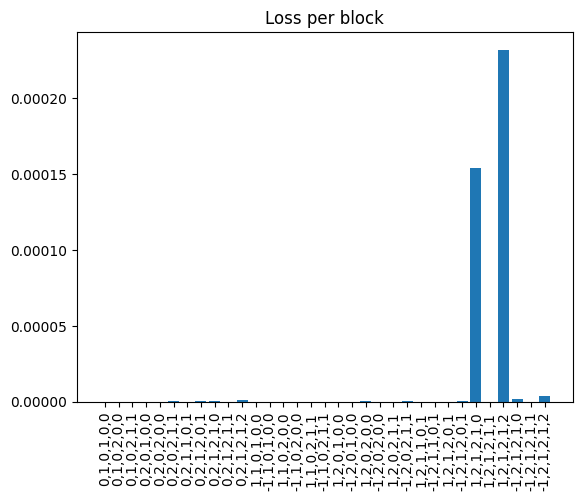

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
s = (0,2,0)
ax.bar(range(len(ridge_block_losses[s])),ridge_block_losses[s]);
ax.set_xticks(np.arange(len(ridge_block_losses[s])))
ax.set_xticklabels(x, rotation=90);
ax.set_title('Loss per block')

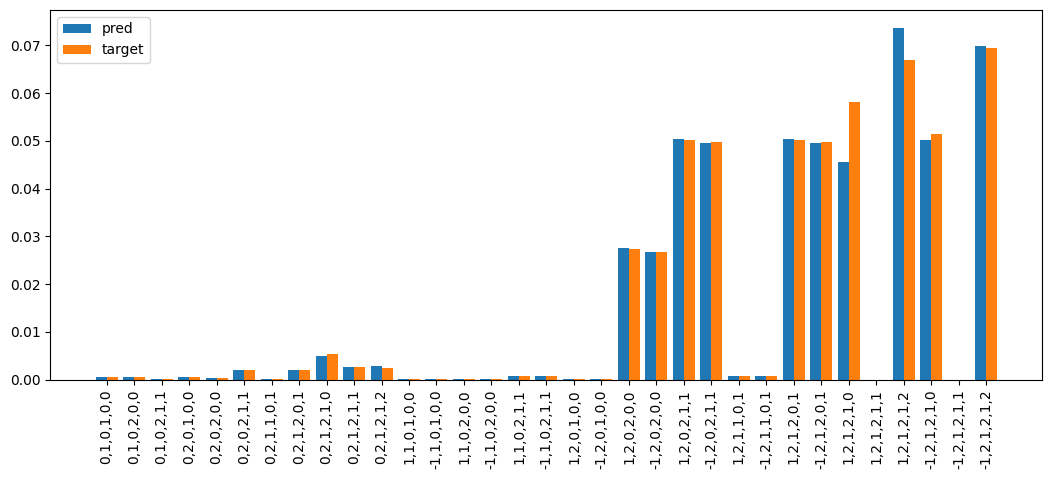

In [32]:
import matplotlib.pyplot as plt
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
# s = (0,0,0)
y = np.array([torch.linalg.norm(b.values) for b in pred_ridge_bias[s]])
yt = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['hex'][s]])
x_ = 2.5*np.arange(len(ridge_block_losses[s]))
ax.bar(x_, y, label = 'pred', width = 1);
ax.bar(x_+1, yt, alpha = 1, label = 'target', width = 1);

ax.set_xticks(2.5*np.arange(len(ridge_block_losses[s]))+0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(loc = 'upper left')

In [33]:
features_per_translation = model_ridge.model_return(hfeat_hexpca)#['hex'])

NameError: name 'hfeat_hexpca' is not defined

In [221]:
# for 
# ridges_bias[0].coef_.shape


In [328]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
# s = (2,0,0)
featblock_norm =[]
for iblock, (k, _) in enumerate(target_coupled_blocks['hex'][s].items()):
    featkey = map_targetkeys_to_featkeys(features_per_translation[s], k, return_key=True)
    
    relevant_feat = np.where(np.abs(ridges_bias[iblock].coef_.flatten()) >1e-8)
#     print(k.values,relevant_feat[0].shape)
    featblock = hfeat['hex'].block(featkey)
    featblock_norm.append(torch.linalg.norm(featblock.values[...,relevant_feat]))
    

[0 6 1 0 6 1 0 0] (7,)
[0 6 1 0 6 2 0 0] (7,)
[0 6 1 0 6 2 1 1] (10,)
[0 6 2 0 6 1 0 0] (7,)
[0 6 2 0 6 2 0 0] (7,)
[0 6 2 0 6 2 1 1] (10,)
[0 6 2 1 6 1 0 1] (10,)
[0 6 2 1 6 2 0 1] (10,)
[0 6 2 1 6 2 1 0] (7,)
[0 6 2 1 6 2 1 1] (3,)
[0 6 2 1 6 2 1 2] (15,)
[1 6 1 0 6 1 0 0] (6,)
[-1  6  1  0  6  1  0  0] (5,)
[1 6 1 0 6 2 0 0] (6,)
[-1  6  1  0  6  2  0  0] (5,)
[1 6 1 0 6 2 1 1] (8,)
[-1  6  1  0  6  2  1  1] (8,)
[1 6 2 0 6 1 0 0] (6,)
[-1  6  2  0  6  1  0  0] (5,)
[1 6 2 0 6 2 0 0] (6,)
[-1  6  2  0  6  2  0  0] (5,)
[1 6 2 0 6 2 1 1] (8,)
[-1  6  2  0  6  2  1  1] (8,)
[1 6 2 1 6 1 0 1] (8,)
[-1  6  2  1  6  1  0  1] (8,)
[1 6 2 1 6 2 0 1] (8,)
[-1  6  2  1  6  2  0  1] (8,)
[1 6 2 1 6 2 1 0] (6,)
[1 6 2 1 6 2 1 1] (1,)
[1 6 2 1 6 2 1 2] (14,)
[-1  6  2  1  6  2  1  0] (5,)
[-1  6  2  1  6  2  1  1] (0,)
[-1  6  2  1  6  2  1  2] (13,)


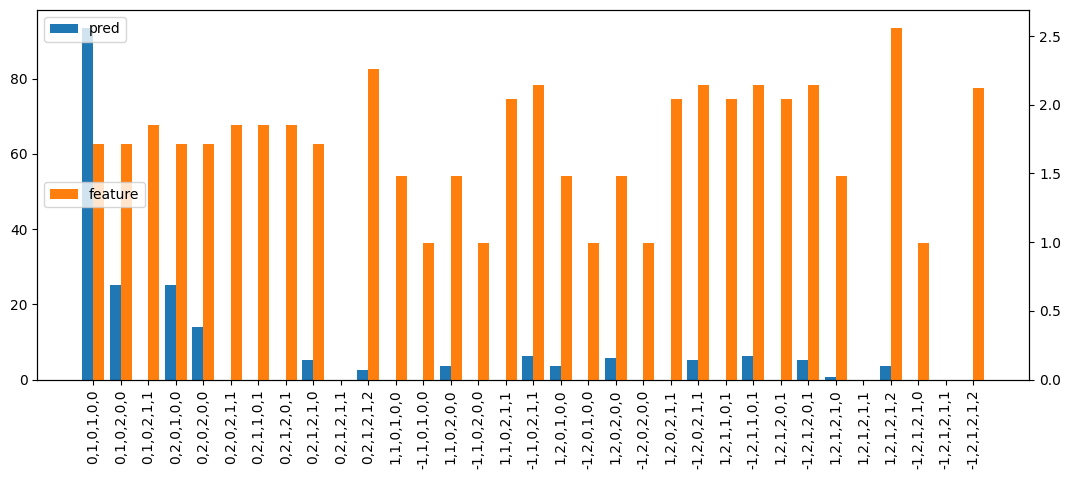

In [330]:
import matplotlib.pyplot as plt
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
# s = (0,0,0)
ax2 = ax.twinx()
y = np.array([torch.linalg.norm(b.values) for b in pred_ridge_bias[s]])
yt = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['hex'][s]])
f = np.array(featblock_norm)

x_ = 2.5*np.arange(len(ridge_block_losses[s]))
ax.bar(x_, yt, label = 'pred', width = 1);
# ax.bar(x_+1, yt, alpha = 1, label = 'target', width = 1);
ax2.bar(x_+1, f, alpha = 1, label = 'feature', width = 1, color = 'tab:orange');

ax.set_xticks(2.5*np.arange(len(ridge_block_losses[s]))+0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(loc = 'upper left')
ax2.legend(loc = 'center left')

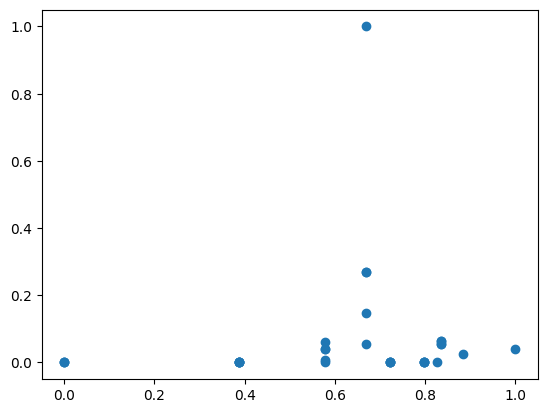

In [331]:
plt.plot(f/f.max(), y/y.max(), 'o')

In [ ]:
import matplotlib.pyplot as plt
fs = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(figsize = (fs[0]*2, fs[1]))
# s = (0,0,0)
y = np.array([torch.linalg.norm(b.values) for b in pred_ridge_bias[s]])
yt = np.array([torch.linalg.norm(b.values) for b in target_coupled_blocks['hex'][s]])
x_ = 2.5*np.arange(len(ridge_block_losses[s]))
ax.bar(x_, y, label = 'pred', width = 1);
ax.bar(x_+1, yt, alpha = 1, label = 'target', width = 1);

ax.set_xticks(2.5*np.arange(len(ridge_block_losses[s]))+0.5)
ax.set_xticklabels(x, rotation=90);
ax.legend(loc = 'upper left')

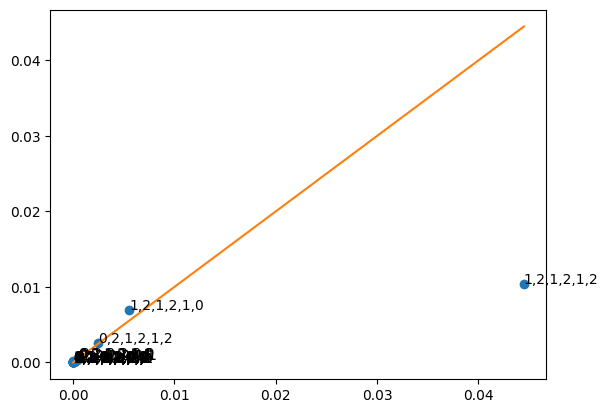

In [94]:
fig, ax = plt.subplots()

y = np.array(y)
yt = np.array(yt)
ax.plot(y, yt, 'o')
xmin = np.min(np.concatenate([y, yt]))
xmax = np.max(np.concatenate([y, yt]))

ax.plot([xmin, xmax], [xmin, xmax])
for y_, yt_, label in zip(y, yt, x):
#     if ~np.isclose(y_/yt_, 1, atol = 1):
#         print(label)
        ax.annotate(label, (y_, yt_))
#     else:
#         print(y_/yt_)


In [95]:
loss_ridge, pred_ridge, ridges, blocklos= train_ridge(model_ridge, target_coupled_blocks['hex'], set_bias=False) # ridge with alphas [logpace[-15,-1, 40]]

0.03675573802820183


/tmp/ipykernel_471662/359595860.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig =plt.figure()


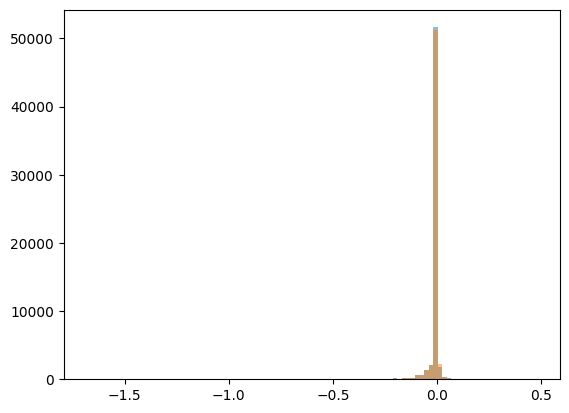

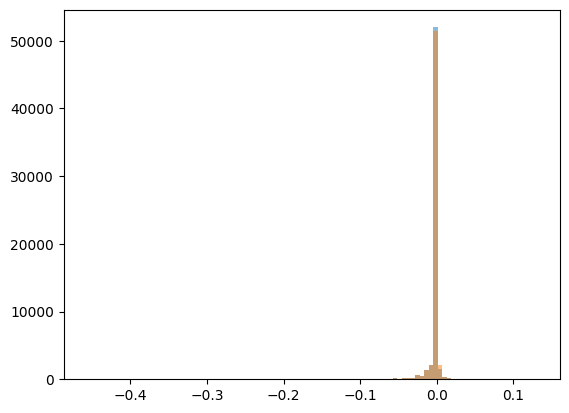

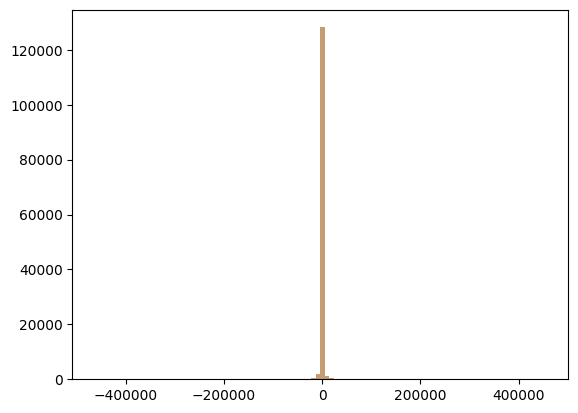

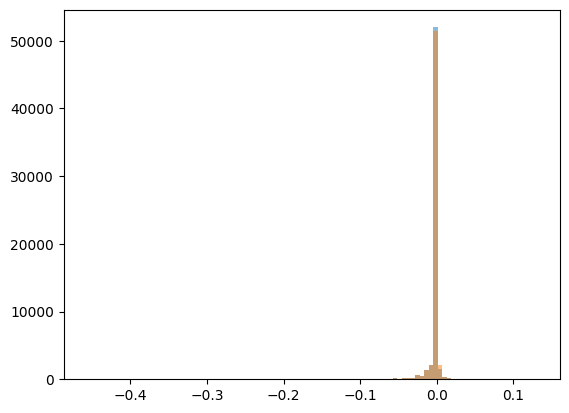

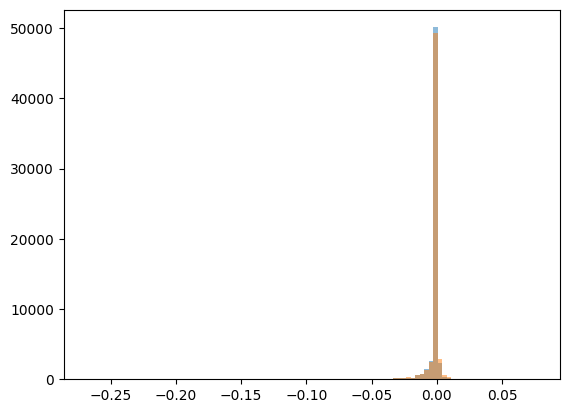

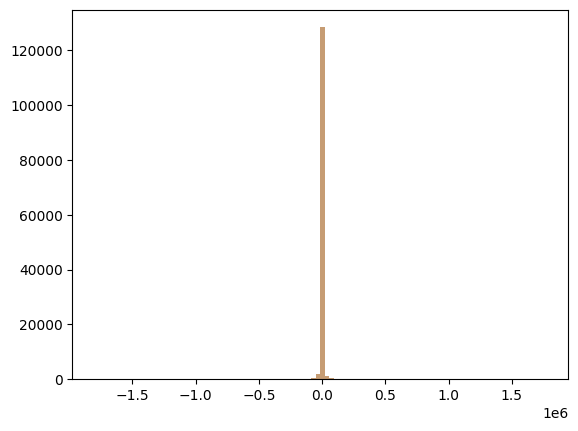

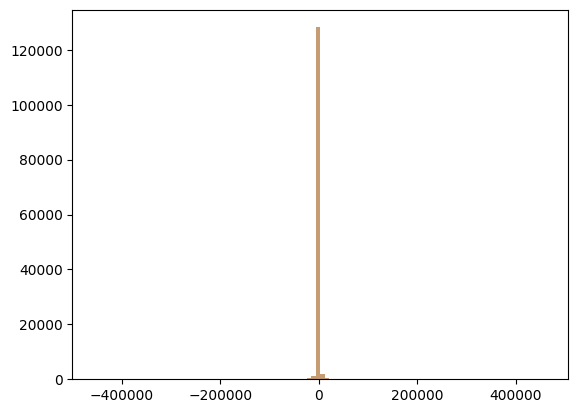

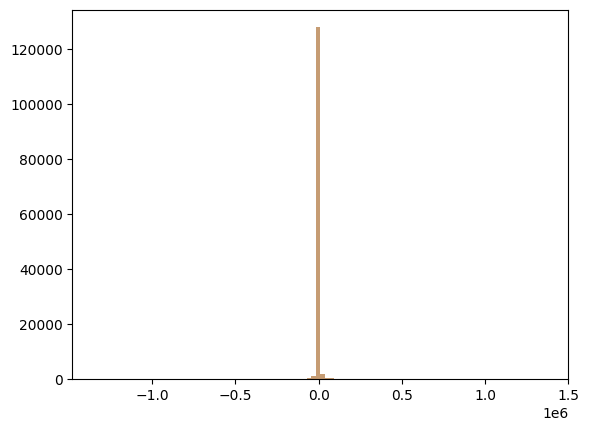

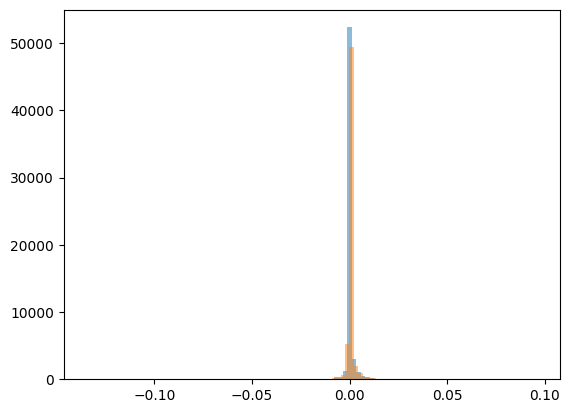

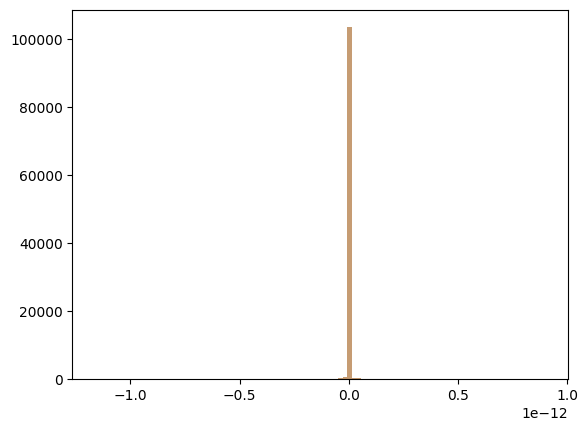

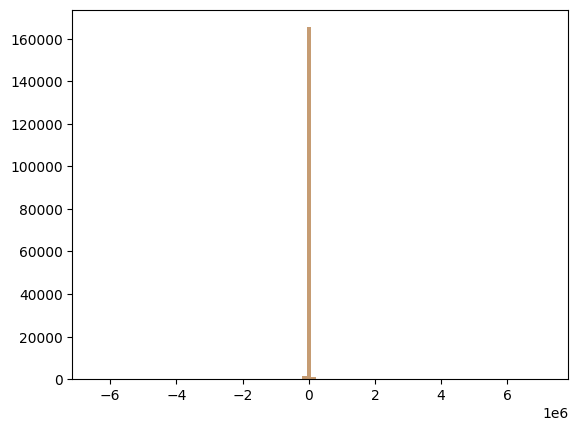

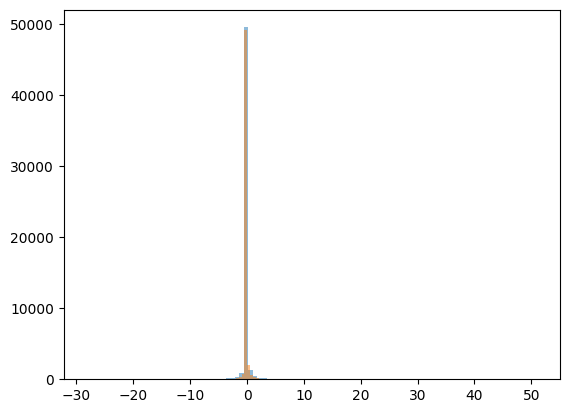

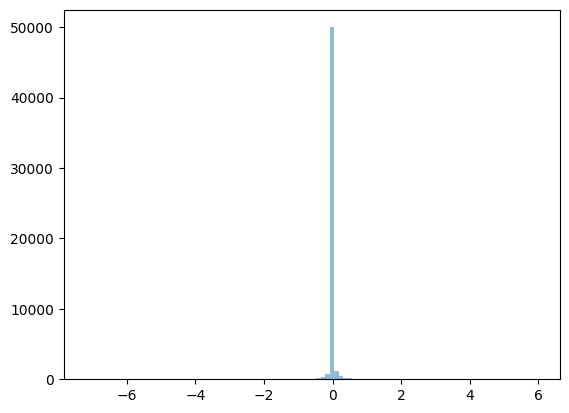

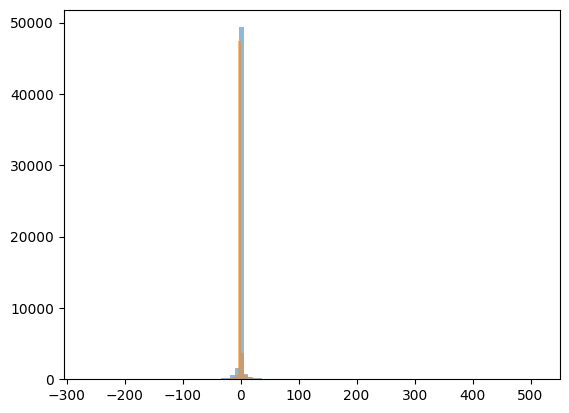

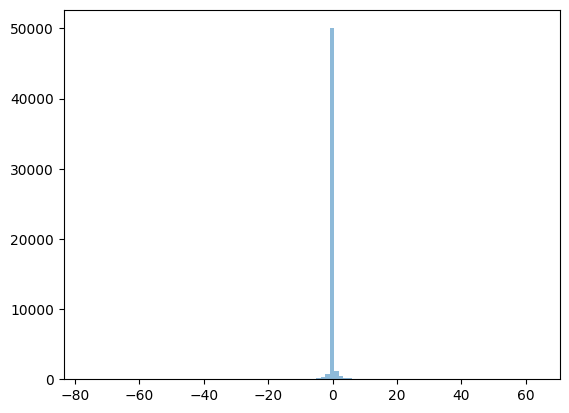

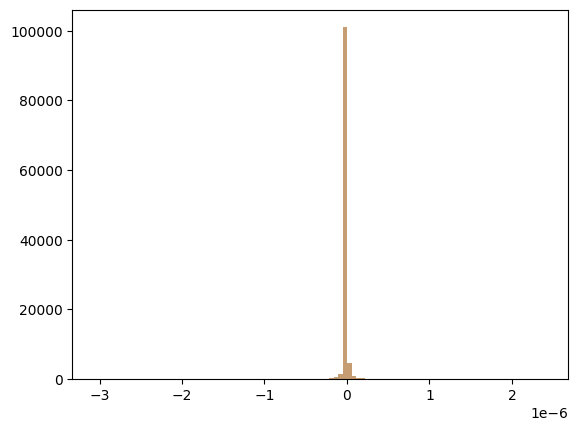

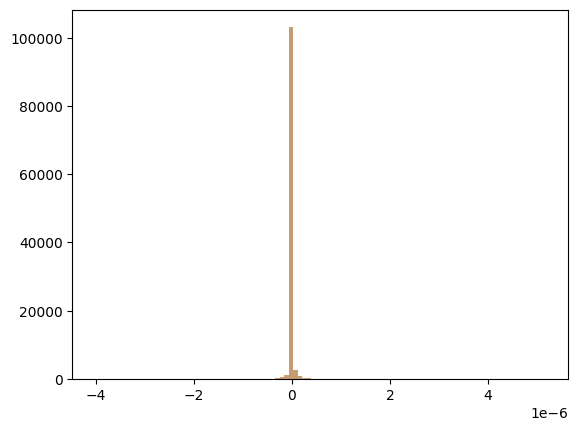

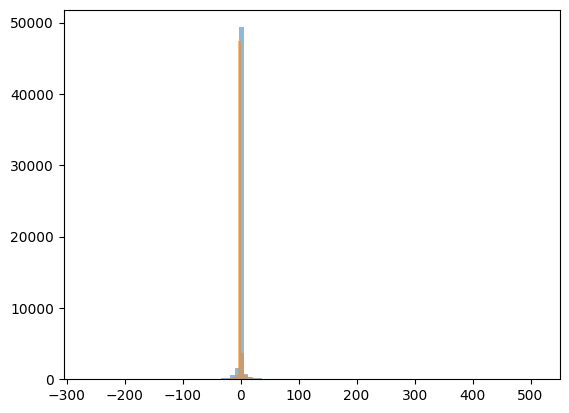

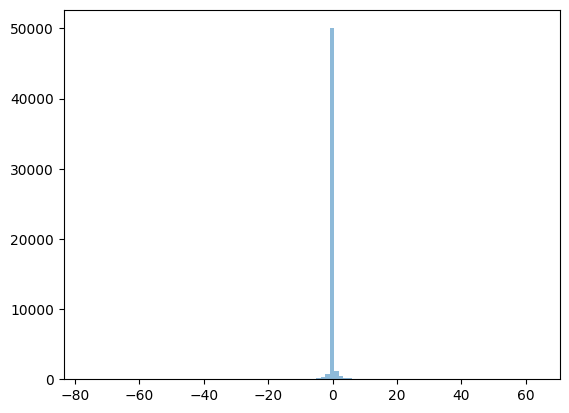

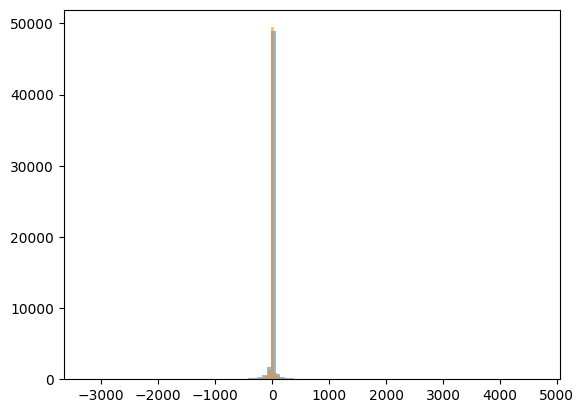

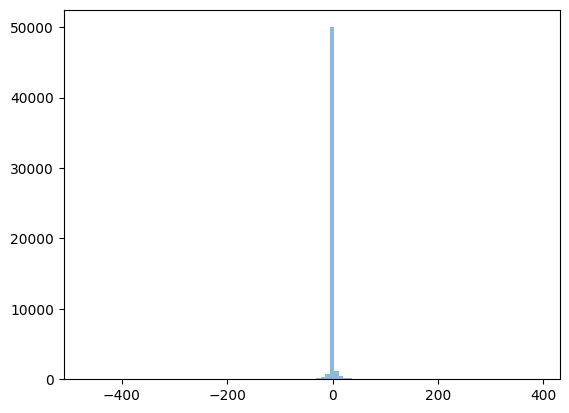

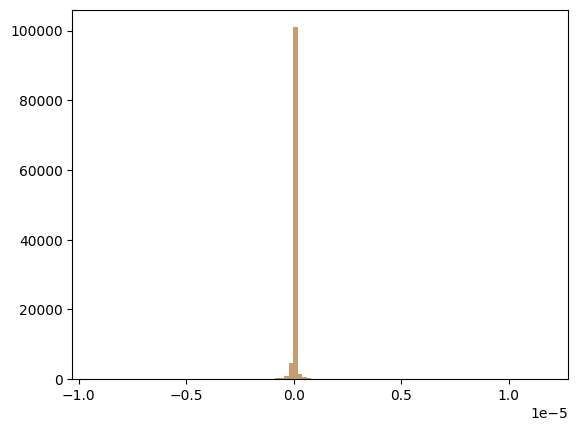

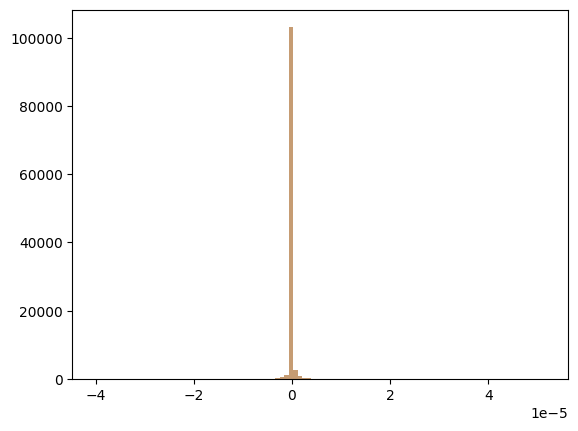

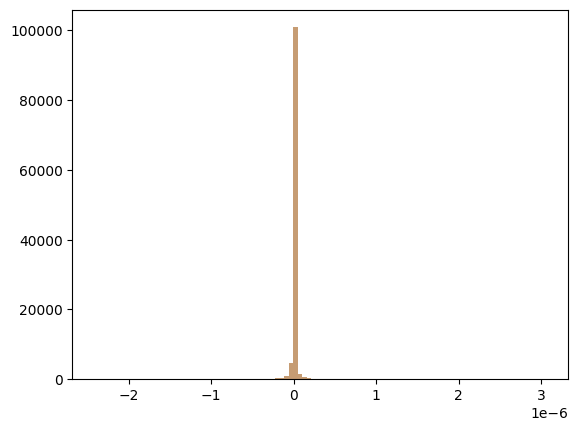

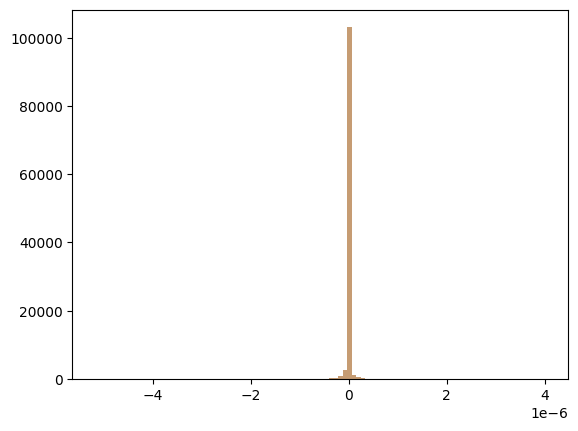

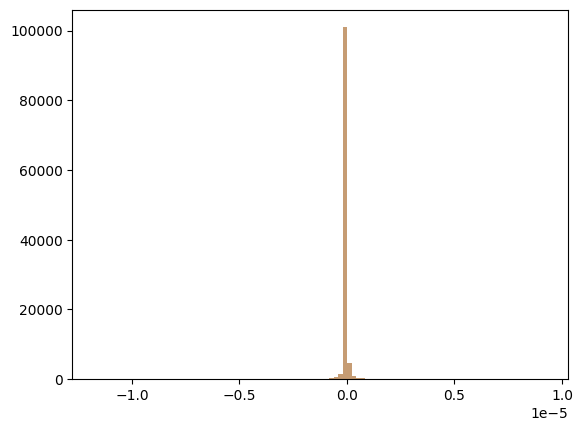

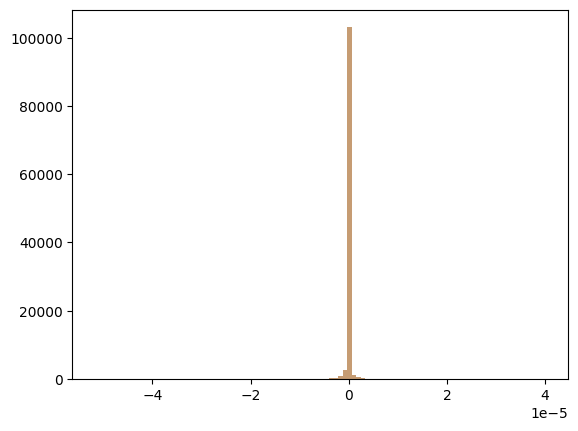

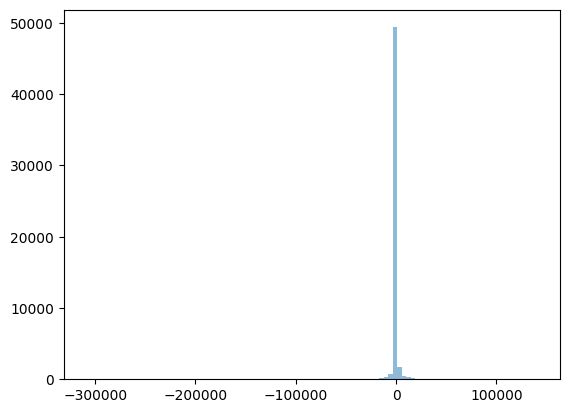

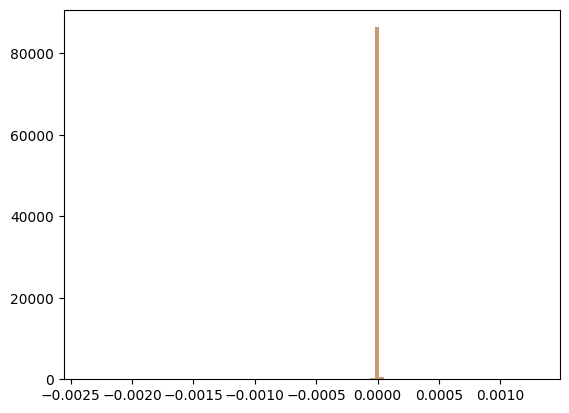

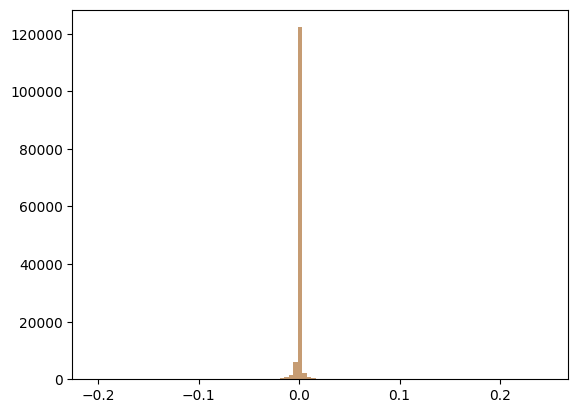

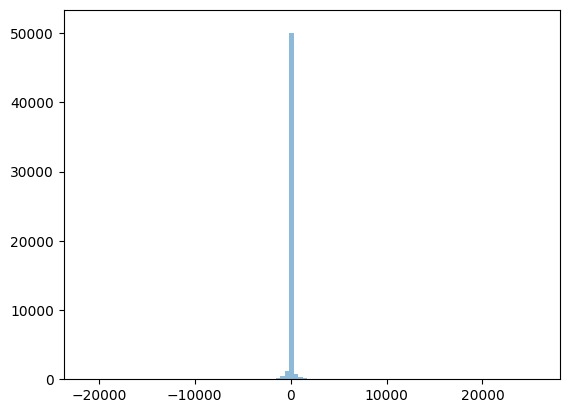

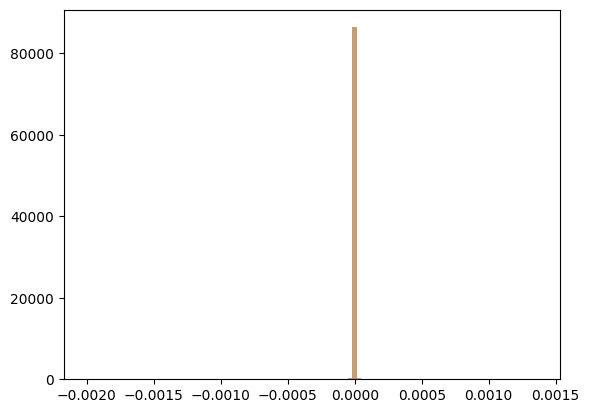

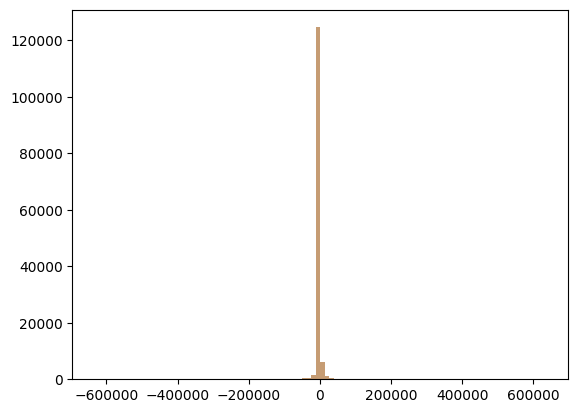

In [43]:
for ridge, rigdetrue in zip(ridges, ridges_bias):
    # print(ridge.coef_ - rigdetrue.coef_)
    # print(ridge.intercept_)# - rigdetrue.intercept_)
    fig =plt.figure()
    plt.hist(ridge.coef_.flatten(), bins=100, alpha=0.5, label="ridge")
    plt.hist(rigdetrue.coef_.flatten(), bins=100, alpha=0.5, label="ridge_bias")